# PIK3CA: Effects of Mutation on IRS1

<b> Standard imports for playing with and plotting data frames. </b>

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statsmodels.stats.multitest

<b> Import CPTAC data </b>

In [4]:
import CPTAC.Endometrial as CPTAC

Loading Endometrial CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter embargo() to open the webpage for more details.


In [5]:
somatic_mutations = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

# PI3KCA mutation and IRS1 proteome abundance 

### Perform a t-test with mutated and non-mutated protein levels

In [6]:
protList = ['IRS1']
pcutoff = 0.05 / len(protList)
gene = 'PIK3CA'

proteomics = proteomics[:100]

sigResults = [];
for protein in protList: 
    if protein in proteomics.columns:
        cross = CPTAC.compare_mutations(proteomics, protein, gene)
        cross = cross[["Mutation", protein]].dropna(axis=0)
        mutated = cross.loc[cross["Mutation"] == "Missense_Mutation"]
        wt = cross.loc[cross["Mutation"] == "Wildtype"]
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        if(ttest[1] <= pcutoff):
            sigResults.append(protein)
            print("Test for " + protein + ": ")
            print(ttest) 

 ### We can now plot the data 

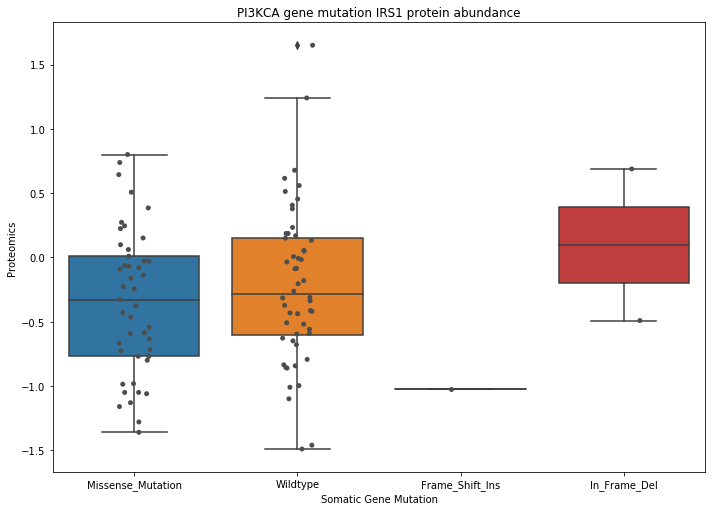

In [7]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
somatic_boxplot = sns.boxplot(data=cross, x="Mutation",y=protein, ax = ax)
somatic_boxplot.set_title("PI3KCA gene mutation IRS1 protein abundance")
somatic_boxplot = sns.stripplot(data=cross, x="Mutation", y=protein,jitter=True, color=".3")
somatic_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Proteomics")
plt.show()

# PI3KCA mutation and IRS1 phosphoproteome abundance 

In [8]:
sites = phos.columns
p_values = []
site_names = []
protein = 'IRS1'


pattern = re.compile(protein)
isInList = filter(pattern.search, sites)
if next(isInList, None) is not None:
    phosphositesdf = CPTAC.compare_mutations(phos, protein, gene)
    phosphositesdf = phosphositesdf.loc[phosphositesdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)
    for site in phosphositesdf.columns:
        if (site is not 'Mutation'):
            sitedf = CPTAC.compare_mutations(phos, site, gene)
            mutateddf = sitedf.loc[sitedf['Mutation'] != 'Wildtype'].dropna(axis=0)
            wtdf = sitedf.loc[sitedf['Mutation'] == 'Wildtype'].dropna(axis=0)
            ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
            p_values.append(ttest[1])
            site_names.append(site)     
                
#We need to remove all 'nan' p-values and their corresponding site names before passing it in for the fdr correction
indexesToRemove=[]

for index in range(0, len(p_values)):
    if np.isnan(p_values[index]):
        indexesToRemove.append(index)

for rem in range( len(indexesToRemove)-1, -1, -1):
    p_values.pop(indexesToRemove[rem])
    site_names.pop(indexesToRemove[rem])
#p_values and site names have now had all entries removed where the corresponding p-value is 'nan'
        

pvalues = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[1]         
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[0]

significant_sites = np.array(site_names)[np.array(areSignificant)]
significant_pvalues = np.array(pvalues)[np.array(areSignificant)]

significant_vals = dict(zip(significant_sites, significant_pvalues))

print(significant_sites)
print(significant_pvalues)
print(significant_vals)

/Users/emilyhosk/anaconda3/envs/research/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/emilyhosk/anaconda3/envs/research/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


['IRS1-S1005' 'IRS1-S1100' 'IRS1-S1101' 'IRS1-S1133' 'IRS1-S1134'
 'IRS1-S270' 'IRS1-S307' 'IRS1-S323' 'IRS1-S330' 'IRS1-S337' 'IRS1-S341'
 'IRS1-S374' 'IRS1-S415' 'IRS1-S527' 'IRS1-S531' 'IRS1-S629' 'IRS1-S636'
 'IRS1-S672' 'IRS1-S766' 'IRS1-T305' 'IRS1-T309' 'IRS1-T530']
[0.03237262 0.00016524 0.00036683 0.01510064 0.00086986 0.00054965
 0.0481304  0.00848105 0.0067178  0.01689065 0.0481304  0.00086986
 0.00290455 0.00886344 0.00134548 0.00036683 0.00239804 0.00848105
 0.00241881 0.00204795 0.00886344 0.02461594]
{'IRS1-S1005': 0.03237261556056832, 'IRS1-S1100': 0.00016523929432243206, 'IRS1-S1101': 0.0003668288032467503, 'IRS1-S1133': 0.01510064359355063, 'IRS1-S1134': 0.0008698589622665647, 'IRS1-S270': 0.0005496494476085143, 'IRS1-S307': 0.04813039926788787, 'IRS1-S323': 0.008481049902878299, 'IRS1-S330': 0.006717802562098508, 'IRS1-S337': 0.016890651234837524, 'IRS1-S341': 0.04813039926788787, 'IRS1-S374': 0.0008698589622665647, 'IRS1-S415': 0.002904550128402398, 'IRS1-S527': 0.0

In [9]:
phosdf = CPTAC.compare_mutations(phos, protein, gene)

phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor']

## Plot all of the phosphoproteomic measurements

In [14]:
protein = 'IRS1'
gene = 'PIK3CA'
phosdf = CPTAC.compare_mutations(phos, protein, gene)
#print(phosdf)
phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis=1)
print(phosdf)

      IRS1-S1005  IRS1-S1078  IRS1-S1100  IRS1-S1101  IRS1-S1131  IRS1-S1132  \
S001     -0.5010         NaN         NaN    -0.20400         NaN         NaN   
S002      0.1760         NaN     -0.3400    -0.58400         NaN         NaN   
S003      0.0839         NaN     -0.1130     0.43800         NaN         NaN   
S004      0.0448   -0.028500     -0.6880    -0.26600         NaN     -0.2310   
S005     -0.2230         NaN     -0.1900    -0.46400         NaN         NaN   
S006     -0.6490         NaN     -0.7970    -0.98850         NaN      0.4780   
S007     -0.2120         NaN      0.3930     0.82650         NaN         NaN   
S008      0.2140    0.207000     -0.2440    -0.30050         NaN         NaN   
S009      0.5540    0.799000     -0.6020    -0.21900         NaN     -0.7120   
S010     -0.0824         NaN     -0.1340     0.15050         NaN     -0.0480   
S011     -0.6440   -0.420000     -0.1270    -0.12700         NaN         NaN   
S012     -1.2900   -0.186000     -0.8270

In [11]:
phosdf.loc[(phosdf['Mutation'] == "Wildtype"), "Mutation"] = "Control"
phosdf.loc[(phosdf['Mutation'] != "Control"), "Mutation"] = "Mutated"

phosdf = pd.melt(phosdf, id_vars=['Mutation'], var_name='Type', value_name='Reading')
phosdf = phosdf.loc[(phosdf["Mutation"] == "Control") | (phosdf["Mutation"] == "Mutated")]
phosdf = phosdf.dropna(axis=0).sort_values(by=['Mutation'], ascending=False)
print(phosdf)
#phosdf = phosdf.loc[(phosdf['Type'] == significant_sites)]
plotdf = None

     Mutation        Type   Reading
0     Mutated  IRS1-S1005 -0.501000
3159  Mutated   IRS1-S421  0.739500
3185  Mutated   IRS1-S421  1.320000
3183  Mutated   IRS1-S421 -0.593500
3176  Mutated   IRS1-S421 -0.252000
3174  Mutated   IRS1-S421 -0.648500
3173  Mutated   IRS1-S421  0.584753
3169  Mutated   IRS1-S421 -0.928500
3167  Mutated   IRS1-S421 -0.011700
3166  Mutated   IRS1-S421  0.115800
3164  Mutated   IRS1-S421  0.213100
3163  Mutated   IRS1-S421 -0.717000
3162  Mutated   IRS1-S421 -0.097000
3160  Mutated   IRS1-S421  0.919000
3154  Mutated   IRS1-S421  0.397000
3189  Mutated   IRS1-S421  0.510500
3152  Mutated   IRS1-S421  1.063000
3142  Mutated   IRS1-S421  1.276000
3139  Mutated   IRS1-S421  0.451500
3137  Mutated   IRS1-S421 -0.970000
3135  Mutated   IRS1-S421  0.020700
3132  Mutated   IRS1-S421 -0.613000
3131  Mutated   IRS1-S421  0.496000
3130  Mutated   IRS1-S421  1.224000
3129  Mutated   IRS1-S421 -0.509000
3127  Mutated   IRS1-S421 -0.405000
3126  Mutated   IRS1-S421  0

In [12]:
interested_sites = ['IRS1-S1100', 'IRS1-S1101', 'IRS1-S1133', 'IRS1-S672', 'IRS1-S766']
for site in interested_sites:
    tempdf = phosdf.loc[(phosdf['Type'] == site)]
    print(tempdf)
    if plotdf is None:
        plotdf = tempdf
    else:
        plotdf = plotdf.append(tempdf)
        
print(plotdf)

    Mutation        Type  Reading
283  Mutated  IRS1-S1100 -0.36200
296  Mutated  IRS1-S1100 -0.20400
297  Mutated  IRS1-S1100 -0.62500
298  Mutated  IRS1-S1100 -0.51900
291  Mutated  IRS1-S1100  0.07850
208  Mutated  IRS1-S1100 -0.60200
202  Mutated  IRS1-S1100 -0.11300
294  Mutated  IRS1-S1100 -0.17000
295  Mutated  IRS1-S1100 -0.19100
209  Mutated  IRS1-S1100 -0.13400
254  Mutated  IRS1-S1100  0.08860
252  Mutated  IRS1-S1100 -0.57800
276  Mutated  IRS1-S1100 -0.52200
242  Mutated  IRS1-S1100 -0.15400
280  Mutated  IRS1-S1100 -0.46600
237  Mutated  IRS1-S1100 -0.11400
273  Mutated  IRS1-S1100  0.02850
274  Mutated  IRS1-S1100  0.18600
269  Mutated  IRS1-S1100 -0.30100
267  Mutated  IRS1-S1100 -0.06680
265  Mutated  IRS1-S1100  0.33200
263  Mutated  IRS1-S1100 -0.36500
262  Mutated  IRS1-S1100 -0.20000
260  Mutated  IRS1-S1100 -0.70300
259  Mutated  IRS1-S1100 -1.37000
223  Mutated  IRS1-S1100  0.04380
289  Mutated  IRS1-S1100  0.02530
222  Mutated  IRS1-S1100 -0.12800
221  Mutated  

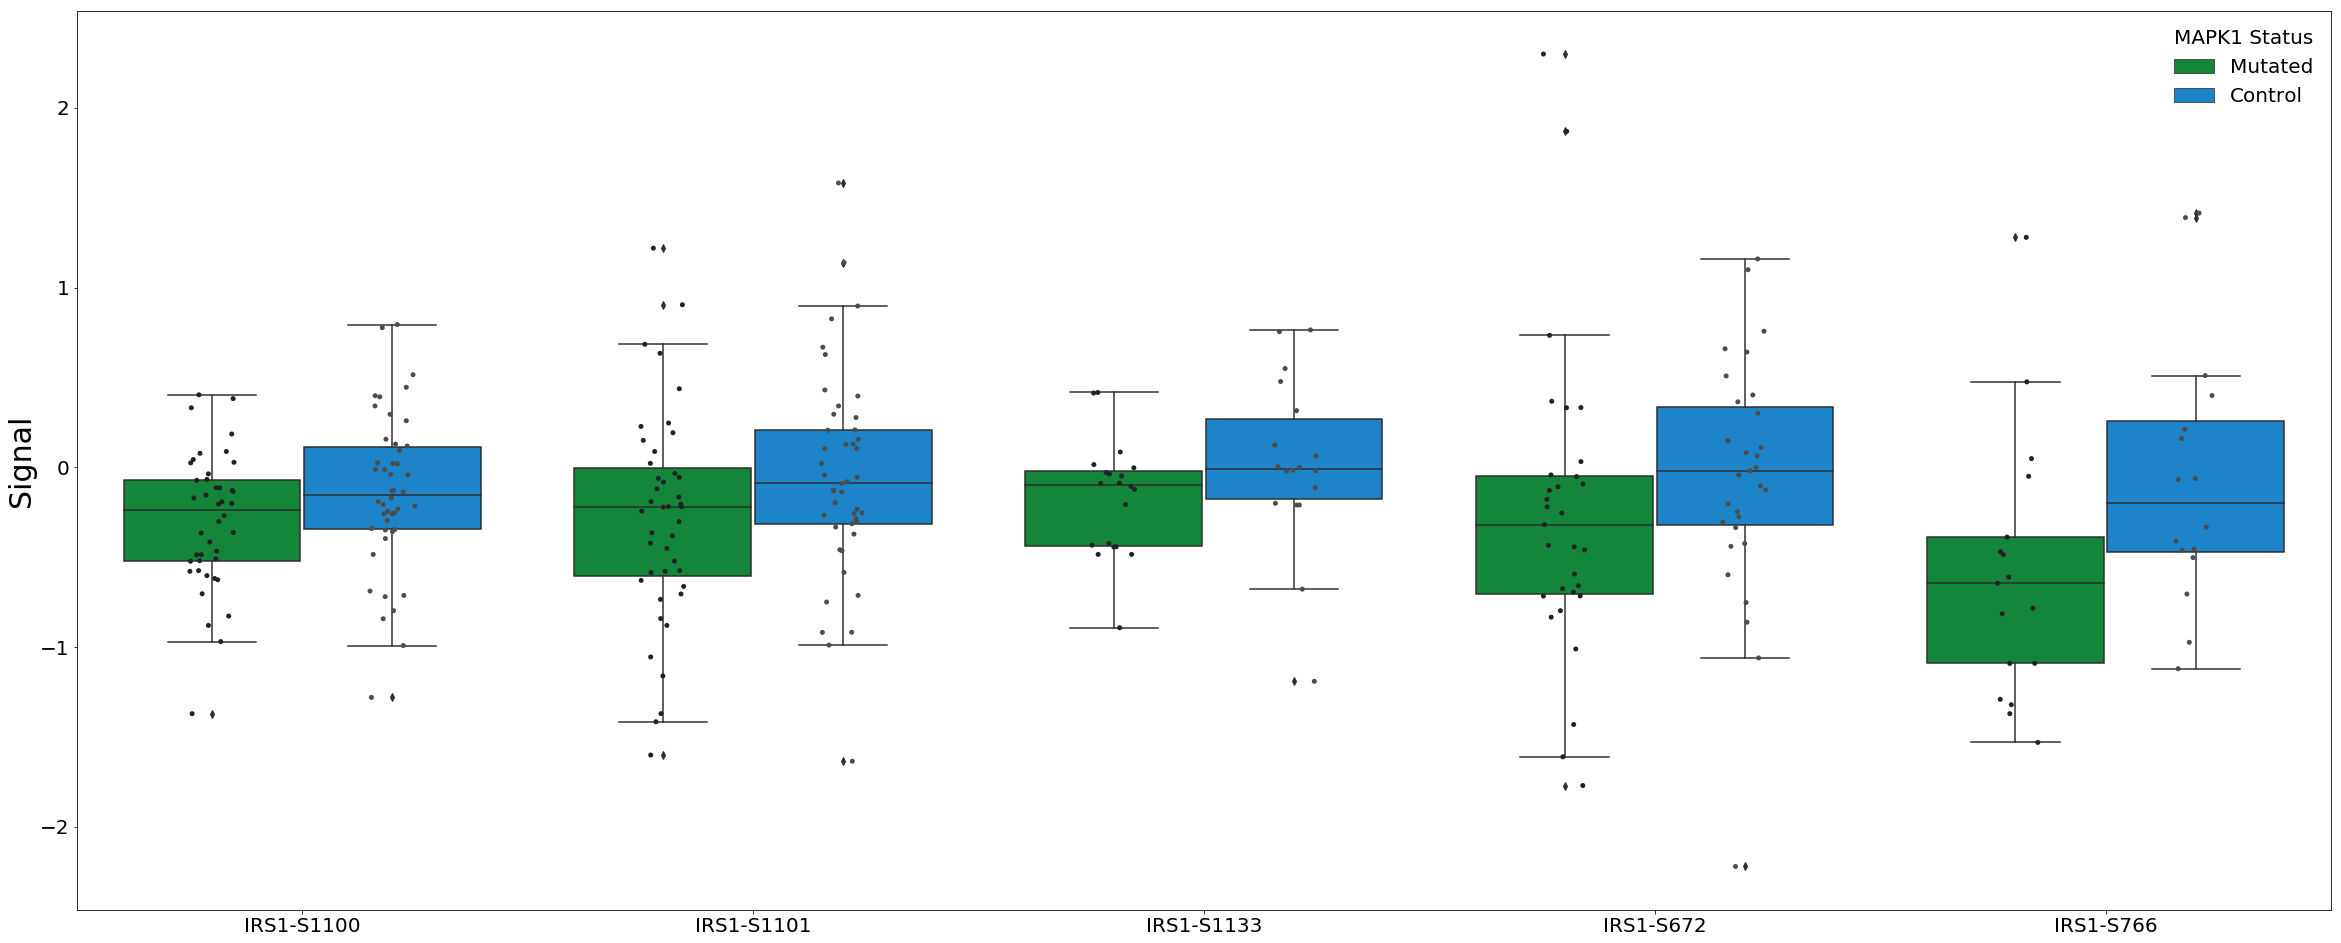

In [13]:
a4_dims = (40.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Mutated": "#009933", "Control": "#008ae6"}

#Create the plot
boxplt = sns.boxplot(x='Type', y='Reading', hue='Mutation', data=plotdf, palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Type', y='Reading', hue='Mutation', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Signal', fontsize='30')
boxplt.tick_params(labelsize='20')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Mutated', 'Control'], title='MAPK1 Status', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
#boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))


fig = boxplt.get_figure()
plt.show()